In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/experiment1/tama/220120_tama_exp1.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df

,created_at,text
0,2022-01-20 15:00:02,二昔前のスマホにはてぶくろモードあるけど、去年モデルにはないな…#tama954
1,2022-01-20 15:00:04,パスタ茹でるのにコンロ3口全部使って時短？！そーれはちょっとどーなのかしら… #tama954
2,2022-01-20 15:00:11,珠「手袋使ってる？」レ「僕をなんだと思ってるんだ！」手袋使わないと思われるのって失礼なことな...
3,2022-01-20 15:00:18,レオさんって神経質なのにせっかちなの？😆 #tama954
4,2022-01-20 15:00:24,手袋が咄嗟に外せない時は鼻の頭で操作した事が複数回ありますわ #tama954
...,...,...
502,2022-01-20 15:30:04,時短のために列ごとにカードまとめてピッピするので、その時に紛れ込ませて… #tama954
503,2022-01-20 15:30:14,#tama954 何事も勉強だな～。
504,2022-01-20 15:30:15,赤江さん「オキュラスのお陰で我々は時計を使わなかった」礼央さん「本当だー」礼央さん、これでい...
505,2022-01-20 15:30:21,赤江さんが金が値上がりしていることを把握しているのは瀧さんに「金を買ったら相場を気にするよう...


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-20 15:00:02,二昔前のスマホにはてぶくろモードあるけど去年モデルにはないな
1,2022-01-20 15:00:04,パスタ茹でるのにコンロ0口全部使って時短そーれはちょっとどーなのかしら
2,2022-01-20 15:00:11,珠手袋使ってるレ僕をなんだと思ってるんだ手袋使わないと思われるのって失礼なことなのか
3,2022-01-20 15:00:18,レオさんって神経質なのにせっかちなの
4,2022-01-20 15:00:24,手袋が咄嗟に外せない時は鼻の頭で操作した事が複数回ありますわ
...,...,...
502,2022-01-20 15:30:04,時短のために列ごとにカードまとめてピッピするのでその時に紛れ込ませて
503,2022-01-20 15:30:14,何事も勉強だな
504,2022-01-20 15:30:15,赤江さんオキュラスのお陰で我は時計を使わなかった礼央さん本当だー礼央さんこれでいいの笑
505,2022-01-20 15:30:21,赤江さんが金が値上がりしていることを把握しているのは瀧さんに金を買ったら相場を気にするように...


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-20 15:00:02,二昔前のスマホにはてぶくろモードあるけど去年モデルにはないな,"[二, 昔, 前, スマホ, てぶくろ, モード, ある, 去年, モデル, ない]"
1,2022-01-20 15:00:04,パスタ茹でるのにコンロ0口全部使って時短そーれはちょっとどーなのかしら,"[パスタ, 茹でる, コンロ, 0, 口, 全部, 使っ, 時短, そ, ー, ちょっと, ..."
2,2022-01-20 15:00:11,珠手袋使ってるレ僕をなんだと思ってるんだ手袋使わないと思われるのって失礼なことなのか,"[珠手, 袋, 使っ, てる, レ, 僕, なん, 思っ, てる, ん, 手袋, 使わ, 思..."
3,2022-01-20 15:00:18,レオさんって神経質なのにせっかちなの,"[レオ, さん, 神経質, せっかち]"
4,2022-01-20 15:00:24,手袋が咄嗟に外せない時は鼻の頭で操作した事が複数回ありますわ,"[手袋, 咄嗟に, 外せ, 時, 鼻, 頭, 操作, し, 事, 複数回, あり]"
...,...,...,...
502,2022-01-20 15:30:04,時短のために列ごとにカードまとめてピッピするのでその時に紛れ込ませて,"[時短, ため, 列, ごと, カード, まとめ, ピッピ, する, 時, 紛れ込ま, せ]"
503,2022-01-20 15:30:14,何事も勉強だな,"[何事, 勉強]"
504,2022-01-20 15:30:15,赤江さんオキュラスのお陰で我は時計を使わなかった礼央さん本当だー礼央さんこれでいいの笑,"[赤江, さん, オキュラス, お陰, 我, 時計, 使わ, 礼央, さん, 本当, だー,..."
505,2022-01-20 15:30:21,赤江さんが金が値上がりしていることを把握しているのは瀧さんに金を買ったら相場を気にするように...,"[赤江, さん, 金, 値上がり, し, いる, こと, 把握, し, いる, の, 瀧, ..."


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-20 15:00:00,"[二, 昔, 前, スマホ, てぶくろ, モード, ある, 去年, モデル, ない, パスタ..."
1,2022-01-20 15:01:00,"[つぶつぶ, 軍手, 川, 0, さん, セコハン, 屋, レコード, 漁る, 時, 着用,..."
2,2022-01-20 15:02:00,"[イジョ, 馴染み, 厚切りジェイソン, 厚木, 厚, 切り, さん, 来, なに, なに,..."
3,2022-01-20 15:03:00,"[何故, 日本, お笑い, やろ, 思っ, ん, 正解, わろ, なんで, コンピュータ, ..."
4,2022-01-20 15:04:00,"[ピン, 太郎, 知っ, てる, dr, memo, ナベプロ, 役員, 二刀流, 厚切りジ..."
5,2022-01-20 15:05:00,"[昨日, アトロク, インテリアデザイナー, 明日, パックン, 邪魔, 存在, 言っ, い..."
6,2022-01-20 15:06:00,"[長野, よく, 来, くれる, 厚切りジェイソン, さん, いつも, 支出, 把握, する..."
7,2022-01-20 15:07:00,"[ジェイソン, 流, カップル, 襲い, 方, ほう, 前, 株主, 優太, ー, コーヒー..."
8,2022-01-20 15:08:00,"[さりげなく, 本題, 入っ, て, 講演会, 始まっ, コーヒー, インスタント, レギュ..."
9,2022-01-20 15:09:00,"[コーヒー, 湯沸かし, インスタントコーヒー, 入れ, 飲む, の, 習慣, 化, し, ..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-20 15:00:02,"[-0.5393169, -0.2257036, -0.6958264, -0.542799..."
1,2022-01-20 15:00:04,"[-0.5369497, -0.38541597, 0.059394423, -0.1952..."
2,2022-01-20 15:00:11,"[-0.6946577, 0.3828343, -0.83389777, -0.708586..."
3,2022-01-20 15:00:18,"[-0.15984258, 0.1280019, -0.16535714, -0.02437..."
4,2022-01-20 15:00:24,"[-0.33495224, 0.07154888, -0.66430676, -0.9368..."
...,...,...
502,2022-01-20 15:30:04,"[-0.14582382, 0.18152727, -1.013625, -0.612789..."
503,2022-01-20 15:30:14,"[0.07420118, -0.849061, -0.42524117, -0.912298..."
504,2022-01-20 15:30:15,"[-0.31494132, 0.3656253, 0.2992833, -0.4159120..."
505,2022-01-20 15:30:21,"[-0.1311769, 0.06898029, -0.30497426, -1.27273..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-20 15:00:00,"[[-0.5393169, -0.2257036, -0.6958264, -0.54279..."
1,2022-01-20 15:01:00,"[[-0.8462945, 0.4578183, 0.2197683, -0.4747883..."
2,2022-01-20 15:02:00,"[[3.4998472, 1.2887872, -1.1040878, -0.2349191..."
3,2022-01-20 15:03:00,"[[0.13237588, -0.28457722, -0.4328921, 1.22210..."
4,2022-01-20 15:04:00,"[0, [-0.5721121, 0.6210478, 0.09672123, -0.372..."
5,2022-01-20 15:05:00,"[[0.28528297, 0.0066023474, -0.7930076, -0.280..."
6,2022-01-20 15:06:00,"[[-0.36803594, 0.70288616, -0.2307108, -0.3308..."
7,2022-01-20 15:07:00,"[[0.47156784, -0.40329048, -0.4569912, -1.1482..."
8,2022-01-20 15:08:00,"[[-0.105344, -0.31281528, -0.044261713, -0.114..."
9,2022-01-20 15:09:00,"[[-0.49981034, -0.19713011, 0.666976, -1.40155..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-20 15:00:00,0.461049,0.544165,0.591593,0.527550,0.150895
1,2022-01-20 15:01:00,0.104734,0.257392,0.334972,0.232770,0.181207
2,2022-01-20 15:02:00,0.098216,0.161235,0.256463,0.174699,0.139708
3,2022-01-20 15:03:00,0.192801,0.279918,0.343920,0.289929,0.129001
4,2022-01-20 15:04:00,0.178465,0.257315,0.387364,0.274360,0.163476
5,2022-01-20 15:05:00,0.189149,0.318486,0.413745,0.319440,0.166810
6,2022-01-20 15:06:00,0.135896,0.330670,0.450830,0.311522,0.183346
7,2022-01-20 15:07:00,0.112171,0.199671,0.257381,0.189430,0.108265
8,2022-01-20 15:08:00,0.259518,0.389115,0.455554,0.350151,0.162149
9,2022-01-20 15:09:00,0.182821,0.297830,0.479469,0.330596,0.207647


In [15]:
df_vectors.to_csv('similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/experiment1/tama/count_exp1.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60+1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.461049,0.544165,0.591593,0.527550,0.150895,7
1,2,0.104734,0.257392,0.334972,0.232770,0.181207,10
2,3,0.098216,0.161235,0.256463,0.174699,0.139708,10
3,4,0.192801,0.279918,0.343920,0.289929,0.129001,9
4,5,0.178465,0.257315,0.387364,0.274360,0.163476,15
5,6,0.189149,0.318486,0.413745,0.319440,0.166810,13
6,7,0.135896,0.330670,0.450830,0.311522,0.183346,9
7,8,0.112171,0.199671,0.257381,0.189430,0.108265,7
8,9,0.259518,0.389115,0.455554,0.350151,0.162149,13
9,10,0.182821,0.297830,0.479469,0.330596,0.207647,12


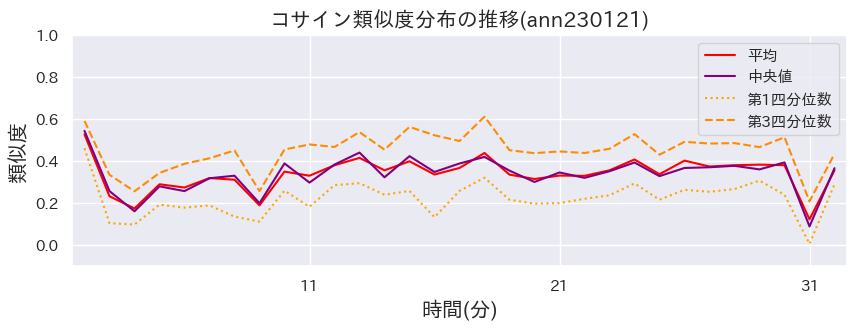

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "コサイン類似度分布の推移(ann230121)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    plt.savefig('quantile.png')


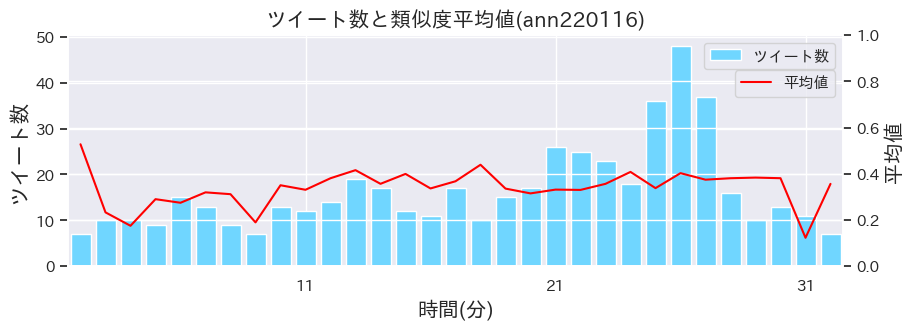

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度平均値(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均値", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('mean.png')


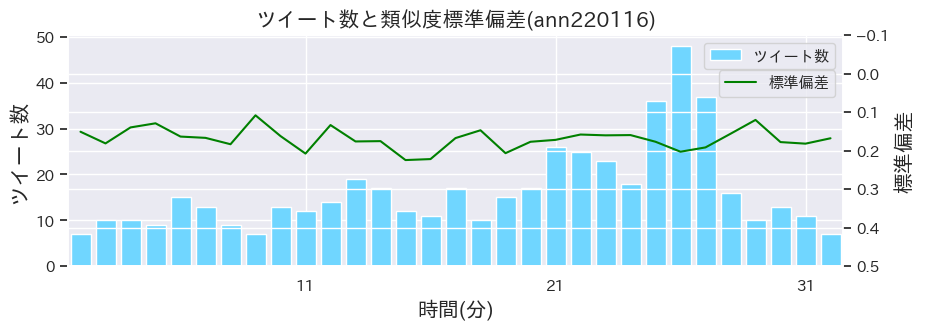

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度標準偏差(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.1)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('stdev.png')
